# Question 2 - Getting Started

In [45]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# On some implementations of matplotlib, you may need to change this value
IMAGE_SIZE = 72

def generate_a_drawing(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata

def generate_a_rectangle(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing(figsize, U, V, noise)


def generate_a_disk(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing(figsize, U, V, noise)

def generate_a_triangle(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = generate_a_drawing(figsize, U, V, noise)
    return [imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]]


def generate_dataset_classification(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros(nb_samples)
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        category = np.random.randint(3)
        if category == 0:
            X[i] = generate_a_rectangle(noise, free_location)
        elif category == 1: 
            X[i] = generate_a_disk(noise, free_location)
        else:
            [X[i], V] = generate_a_triangle(noise, free_location)
        Y[i] = category
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

def generate_test_set_classification():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_classification(300, 20, True)
    Y_test = np_utils.to_categorical(Y_test, 3) 
    return [X_test, Y_test]

def generate_dataset_regression(nb_samples, noise=0.0):
    # Getting im_size:
    im_size = generate_a_triangle()[0].shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples, 6])
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        [X[i], Y[i]] = generate_a_triangle(noise, True)
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

import matplotlib.patches as patches

def visualize_prediction(x, y):
    fig, ax = plt.subplots(figsize=(5, 5))
    I = x.reshape((IMAGE_SIZE,IMAGE_SIZE))
    ax.imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])

    xy = y.reshape(3,2)
    tri = patches.Polygon(xy, closed=True, fill = False, edgecolor = 'r', linewidth = 5, alpha = 0.5)
    ax.add_patch(tri)

    plt.show()

def generate_test_set_regression():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_regression(300, 20)
    return [X_test, Y_test]

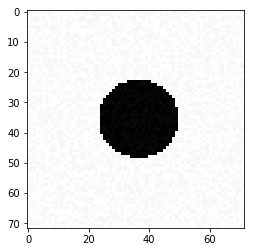

In [46]:
im = generate_a_disk(10)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

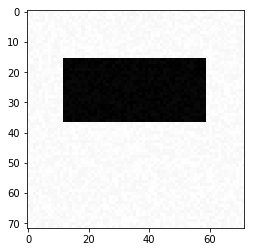

In [48]:
im = generate_a_rectangle(10, True)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

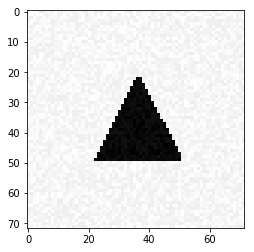

In [49]:
[im, v] = generate_a_triangle(20, False)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

# Question 3 - Simple Classification

In [26]:
#Imports
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Conv2D, MaxPooling2D, Flatten
from keras.optimizers import SGD, Adam
from keras.utils import np_utils

In [27]:
# Generating Training Data
[X_train, Y_train] = generate_dataset_classification(300, 20)
[X_valid, Y_valid] = generate_dataset_classification(60, 20)
Y_train = np_utils.to_categorical(Y_train)
Y_valid = np_utils.to_categorical(Y_valid)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
Creating data:
0
10
20
30
40
50


##  Stochastic gradient descent optimizer

In [68]:
# Defining the Network
nb_neurons = 3
model_sgd = Sequential()
model_sgd.add(Dense(nb_neurons, activation='softmax', input_shape=(IMAGE_SIZE*IMAGE_SIZE,)))
    
# Defining the Optimization Method
sgd = SGD(lr=0.001, momentum=0.0, decay=0.0, nesterov=False)
model_sgd.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

# Running the Optimization
model_sgd.fit(X_train, Y_train, epochs=1000, batch_size=32, validation_data=(X_valid, Y_valid))

Train on 300 samples, validate on 60 samples
Epoch 1/1000
300/300 [==============================] - 0s - loss: 1.2946 - acc: 0.2700 - val_loss: 1.1222 - val_acc: 0.3833
Epoch 2/1000
300/300 [==============================] - 0s - loss: 1.0864 - acc: 0.4233 - val_loss: 1.1143 - val_acc: 0.4167
Epoch 3/1000
300/300 [==============================] - 0s - loss: 1.0493 - acc: 0.5100 - val_loss: 0.9236 - val_acc: 0.5000
Epoch 4/1000
300/300 [==============================] - 0s - loss: 0.8760 - acc: 0.6300 - val_loss: 0.7898 - val_acc: 0.7833
Epoch 5/1000
300/300 [==============================] - 0s - loss: 0.8568 - acc: 0.6267 - val_loss: 0.7784 - val_acc: 0.6667
Epoch 6/1000
300/300 [==============================] - 0s - loss: 0.7546 - acc: 0.7267 - val_loss: 0.7742 - val_acc: 0.6333
Epoch 7/1000
300/300 [==============================] - 0s - loss: 0.7266 - acc: 0.7600 - val_loss: 0.6790 - val_acc: 0.8167
Epoch 8/1000
300/300 [==============================] - 0s - loss: 0.6797 - acc:

300/300 [==============================] - 0s - loss: 0.2534 - acc: 0.9567 - val_loss: 0.2625 - val_acc: 0.9333
Epoch 66/1000
300/300 [==============================] - 0s - loss: 0.2571 - acc: 0.9533 - val_loss: 0.2575 - val_acc: 0.9667
Epoch 67/1000
300/300 [==============================] - 0s - loss: 0.2488 - acc: 0.9600 - val_loss: 0.2587 - val_acc: 0.9333
Epoch 68/1000
300/300 [==============================] - 0s - loss: 0.2479 - acc: 0.9600 - val_loss: 0.2534 - val_acc: 0.9333
Epoch 69/1000
300/300 [==============================] - 0s - loss: 0.2433 - acc: 0.9600 - val_loss: 0.2742 - val_acc: 0.9000
Epoch 70/1000
300/300 [==============================] - 0s - loss: 0.2395 - acc: 0.9567 - val_loss: 0.2512 - val_acc: 1.0000
Epoch 71/1000
300/300 [==============================] - 0s - loss: 0.2387 - acc: 0.9667 - val_loss: 0.2569 - val_acc: 0.9000
Epoch 72/1000
300/300 [==============================] - 0s - loss: 0.2447 - acc: 0.9500 - val_loss: 0.2469 - val_acc: 0.9333
Epoch 

300/300 [==============================] - 0s - loss: 0.1650 - acc: 0.9700 - val_loss: 0.1685 - val_acc: 1.0000
Epoch 130/1000
300/300 [==============================] - 0s - loss: 0.1646 - acc: 0.9800 - val_loss: 0.1733 - val_acc: 0.9500
Epoch 131/1000
300/300 [==============================] - 0s - loss: 0.1595 - acc: 0.9733 - val_loss: 0.1694 - val_acc: 0.9667
Epoch 132/1000
300/300 [==============================] - 0s - loss: 0.1615 - acc: 0.9700 - val_loss: 0.1775 - val_acc: 0.9333
Epoch 133/1000
300/300 [==============================] - 0s - loss: 0.1601 - acc: 0.9800 - val_loss: 0.1664 - val_acc: 0.9833
Epoch 134/1000
300/300 [==============================] - 0s - loss: 0.1581 - acc: 0.9800 - val_loss: 0.1710 - val_acc: 0.9500
Epoch 135/1000
300/300 [==============================] - 0s - loss: 0.1551 - acc: 0.9767 - val_loss: 0.1999 - val_acc: 0.9000
Epoch 136/1000
300/300 [==============================] - 0s - loss: 0.1681 - acc: 0.9700 - val_loss: 0.1617 - val_acc: 1.0000

300/300 [==============================] - 0s - loss: 0.1226 - acc: 0.9900 - val_loss: 0.1419 - val_acc: 0.9500
Epoch 194/1000
300/300 [==============================] - 0s - loss: 0.1229 - acc: 0.9833 - val_loss: 0.1312 - val_acc: 0.9833
Epoch 195/1000
300/300 [==============================] - 0s - loss: 0.1199 - acc: 0.9900 - val_loss: 0.1265 - val_acc: 1.0000
Epoch 196/1000
300/300 [==============================] - 0s - loss: 0.1214 - acc: 0.9867 - val_loss: 0.1248 - val_acc: 1.0000
Epoch 197/1000
300/300 [==============================] - 0s - loss: 0.1189 - acc: 0.9933 - val_loss: 0.1431 - val_acc: 0.9500
Epoch 198/1000
300/300 [==============================] - 0s - loss: 0.1195 - acc: 0.9900 - val_loss: 0.1375 - val_acc: 0.9667
Epoch 199/1000
300/300 [==============================] - 0s - loss: 0.1166 - acc: 0.9867 - val_loss: 0.1226 - val_acc: 1.0000
Epoch 200/1000
300/300 [==============================] - 0s - loss: 0.1188 - acc: 0.9833 - val_loss: 0.1222 - val_acc: 1.0000

300/300 [==============================] - 0s - loss: 0.0976 - acc: 0.9867 - val_loss: 0.1178 - val_acc: 0.9667
Epoch 258/1000
300/300 [==============================] - 0s - loss: 0.0974 - acc: 0.9933 - val_loss: 0.1019 - val_acc: 1.0000
Epoch 259/1000
300/300 [==============================] - 0s - loss: 0.0969 - acc: 0.9900 - val_loss: 0.1151 - val_acc: 0.9667
Epoch 260/1000
300/300 [==============================] - 0s - loss: 0.0980 - acc: 0.9833 - val_loss: 0.1009 - val_acc: 1.0000
Epoch 261/1000
300/300 [==============================] - 0s - loss: 0.0992 - acc: 0.9933 - val_loss: 0.0996 - val_acc: 1.0000
Epoch 262/1000
300/300 [==============================] - 0s - loss: 0.0971 - acc: 0.9933 - val_loss: 0.1043 - val_acc: 1.0000
Epoch 263/1000
300/300 [==============================] - 0s - loss: 0.0977 - acc: 0.9900 - val_loss: 0.1091 - val_acc: 0.9833
Epoch 264/1000
300/300 [==============================] - 0s - loss: 0.0970 - acc: 0.9867 - val_loss: 0.1021 - val_acc: 1.0000

300/300 [==============================] - 0s - loss: 0.0817 - acc: 0.9933 - val_loss: 0.0839 - val_acc: 1.0000
Epoch 322/1000
300/300 [==============================] - 0s - loss: 0.0810 - acc: 0.9933 - val_loss: 0.0833 - val_acc: 1.0000
Epoch 323/1000
300/300 [==============================] - 0s - loss: 0.0797 - acc: 0.9967 - val_loss: 0.0928 - val_acc: 1.0000
Epoch 324/1000
300/300 [==============================] - 0s - loss: 0.0806 - acc: 0.9933 - val_loss: 0.0958 - val_acc: 0.9833
Epoch 325/1000
300/300 [==============================] - 0s - loss: 0.0809 - acc: 0.9900 - val_loss: 0.0871 - val_acc: 1.0000
Epoch 326/1000
300/300 [==============================] - 0s - loss: 0.0808 - acc: 0.9967 - val_loss: 0.0953 - val_acc: 0.9833
Epoch 327/1000
300/300 [==============================] - 0s - loss: 0.0812 - acc: 0.9900 - val_loss: 0.0906 - val_acc: 1.0000
Epoch 328/1000
300/300 [==============================] - 0s - loss: 0.0806 - acc: 0.9933 - val_loss: 0.0822 - val_acc: 1.0000

300/300 [==============================] - 0s - loss: 0.0702 - acc: 1.0000 - val_loss: 0.0731 - val_acc: 1.0000
Epoch 386/1000
300/300 [==============================] - 0s - loss: 0.0691 - acc: 0.9967 - val_loss: 0.0774 - val_acc: 1.0000
Epoch 387/1000
300/300 [==============================] - 0s - loss: 0.0697 - acc: 0.9933 - val_loss: 0.0763 - val_acc: 1.0000
Epoch 388/1000
300/300 [==============================] - 0s - loss: 0.0688 - acc: 1.0000 - val_loss: 0.0749 - val_acc: 1.0000
Epoch 389/1000
300/300 [==============================] - 0s - loss: 0.0686 - acc: 0.9933 - val_loss: 0.0711 - val_acc: 1.0000
Epoch 390/1000
300/300 [==============================] - 0s - loss: 0.0692 - acc: 0.9933 - val_loss: 0.0720 - val_acc: 1.0000
Epoch 391/1000
300/300 [==============================] - 0s - loss: 0.0686 - acc: 1.0000 - val_loss: 0.0756 - val_acc: 1.0000
Epoch 392/1000
300/300 [==============================] - 0s - loss: 0.0682 - acc: 0.9967 - val_loss: 0.0767 - val_acc: 1.0000

300/300 [==============================] - 0s - loss: 0.0608 - acc: 0.9967 - val_loss: 0.0662 - val_acc: 1.0000
Epoch 450/1000
300/300 [==============================] - 0s - loss: 0.0606 - acc: 1.0000 - val_loss: 0.0652 - val_acc: 1.0000
Epoch 451/1000
300/300 [==============================] - 0s - loss: 0.0608 - acc: 0.9967 - val_loss: 0.0622 - val_acc: 1.0000
Epoch 452/1000
300/300 [==============================] - 0s - loss: 0.0604 - acc: 0.9967 - val_loss: 0.0626 - val_acc: 1.0000
Epoch 453/1000
300/300 [==============================] - 0s - loss: 0.0596 - acc: 0.9967 - val_loss: 0.0639 - val_acc: 1.0000
Epoch 454/1000
300/300 [==============================] - 0s - loss: 0.0597 - acc: 1.0000 - val_loss: 0.0656 - val_acc: 1.0000
Epoch 455/1000
300/300 [==============================] - 0s - loss: 0.0625 - acc: 1.0000 - val_loss: 0.0629 - val_acc: 1.0000
Epoch 456/1000
300/300 [==============================] - 0s - loss: 0.0595 - acc: 1.0000 - val_loss: 0.0626 - val_acc: 1.0000

300/300 [==============================] - 0s - loss: 0.0527 - acc: 1.0000 - val_loss: 0.0683 - val_acc: 1.0000
Epoch 514/1000
300/300 [==============================] - 0s - loss: 0.0549 - acc: 0.9933 - val_loss: 0.0598 - val_acc: 1.0000
Epoch 515/1000
300/300 [==============================] - 0s - loss: 0.0540 - acc: 1.0000 - val_loss: 0.0559 - val_acc: 1.0000
Epoch 516/1000
300/300 [==============================] - 0s - loss: 0.0535 - acc: 1.0000 - val_loss: 0.0556 - val_acc: 1.0000
Epoch 517/1000
300/300 [==============================] - 0s - loss: 0.0533 - acc: 1.0000 - val_loss: 0.0561 - val_acc: 1.0000
Epoch 518/1000
300/300 [==============================] - 0s - loss: 0.0531 - acc: 1.0000 - val_loss: 0.0585 - val_acc: 1.0000
Epoch 519/1000
300/300 [==============================] - 0s - loss: 0.0535 - acc: 1.0000 - val_loss: 0.0569 - val_acc: 1.0000
Epoch 520/1000
300/300 [==============================] - 0s - loss: 0.0529 - acc: 1.0000 - val_loss: 0.0558 - val_acc: 1.0000

300/300 [==============================] - 0s - loss: 0.0476 - acc: 1.0000 - val_loss: 0.0533 - val_acc: 1.0000
Epoch 578/1000
300/300 [==============================] - 0s - loss: 0.0481 - acc: 1.0000 - val_loss: 0.0519 - val_acc: 1.0000
Epoch 579/1000
300/300 [==============================] - 0s - loss: 0.0481 - acc: 1.0000 - val_loss: 0.0502 - val_acc: 1.0000
Epoch 580/1000
300/300 [==============================] - 0s - loss: 0.0481 - acc: 1.0000 - val_loss: 0.0502 - val_acc: 1.0000
Epoch 581/1000
300/300 [==============================] - 0s - loss: 0.0490 - acc: 1.0000 - val_loss: 0.0519 - val_acc: 1.0000
Epoch 582/1000
300/300 [==============================] - 0s - loss: 0.0477 - acc: 1.0000 - val_loss: 0.0509 - val_acc: 1.0000
Epoch 583/1000
300/300 [==============================] - 0s - loss: 0.0479 - acc: 1.0000 - val_loss: 0.0498 - val_acc: 1.0000
Epoch 584/1000
300/300 [==============================] - 0s - loss: 0.0478 - acc: 1.0000 - val_loss: 0.0519 - val_acc: 1.0000

300/300 [==============================] - 0s - loss: 0.0442 - acc: 1.0000 - val_loss: 0.0471 - val_acc: 1.0000
Epoch 642/1000
300/300 [==============================] - 0s - loss: 0.0440 - acc: 1.0000 - val_loss: 0.0460 - val_acc: 1.0000
Epoch 643/1000
300/300 [==============================] - 0s - loss: 0.0435 - acc: 1.0000 - val_loss: 0.0479 - val_acc: 1.0000
Epoch 644/1000
300/300 [==============================] - 0s - loss: 0.0434 - acc: 1.0000 - val_loss: 0.0456 - val_acc: 1.0000
Epoch 645/1000
300/300 [==============================] - 0s - loss: 0.0436 - acc: 1.0000 - val_loss: 0.0458 - val_acc: 1.0000
Epoch 646/1000
300/300 [==============================] - 0s - loss: 0.0439 - acc: 1.0000 - val_loss: 0.0488 - val_acc: 1.0000
Epoch 647/1000
300/300 [==============================] - 0s - loss: 0.0442 - acc: 1.0000 - val_loss: 0.0459 - val_acc: 1.0000
Epoch 648/1000
300/300 [==============================] - 0s - loss: 0.0440 - acc: 1.0000 - val_loss: 0.0465 - val_acc: 1.0000

300/300 [==============================] - 0s - loss: 0.0411 - acc: 1.0000 - val_loss: 0.0429 - val_acc: 1.0000
Epoch 706/1000
300/300 [==============================] - 0s - loss: 0.0399 - acc: 1.0000 - val_loss: 0.0431 - val_acc: 1.0000
Epoch 707/1000
300/300 [==============================] - 0s - loss: 0.0398 - acc: 1.0000 - val_loss: 0.0435 - val_acc: 1.0000
Epoch 708/1000
300/300 [==============================] - 0s - loss: 0.0397 - acc: 1.0000 - val_loss: 0.0422 - val_acc: 1.0000
Epoch 709/1000
300/300 [==============================] - 0s - loss: 0.0406 - acc: 1.0000 - val_loss: 0.0432 - val_acc: 1.0000
Epoch 710/1000
300/300 [==============================] - 0s - loss: 0.0396 - acc: 1.0000 - val_loss: 0.0421 - val_acc: 1.0000
Epoch 711/1000
300/300 [==============================] - 0s - loss: 0.0397 - acc: 1.0000 - val_loss: 0.0416 - val_acc: 1.0000
Epoch 712/1000
300/300 [==============================] - 0s - loss: 0.0398 - acc: 1.0000 - val_loss: 0.0437 - val_acc: 1.0000

300/300 [==============================] - 0s - loss: 0.0369 - acc: 1.0000 - val_loss: 0.0398 - val_acc: 1.0000
Epoch 770/1000
300/300 [==============================] - 0s - loss: 0.0370 - acc: 1.0000 - val_loss: 0.0396 - val_acc: 1.0000
Epoch 771/1000
300/300 [==============================] - 0s - loss: 0.0367 - acc: 1.0000 - val_loss: 0.0401 - val_acc: 1.0000
Epoch 772/1000
300/300 [==============================] - 0s - loss: 0.0367 - acc: 1.0000 - val_loss: 0.0417 - val_acc: 1.0000
Epoch 773/1000
300/300 [==============================] - 0s - loss: 0.0368 - acc: 1.0000 - val_loss: 0.0385 - val_acc: 1.0000
Epoch 774/1000
300/300 [==============================] - 0s - loss: 0.0367 - acc: 1.0000 - val_loss: 0.0390 - val_acc: 1.0000
Epoch 775/1000
300/300 [==============================] - 0s - loss: 0.0367 - acc: 1.0000 - val_loss: 0.0399 - val_acc: 1.0000
Epoch 776/1000
300/300 [==============================] - 0s - loss: 0.0369 - acc: 1.0000 - val_loss: 0.0400 - val_acc: 1.0000

300/300 [==============================] - 0s - loss: 0.0342 - acc: 1.0000 - val_loss: 0.0363 - val_acc: 1.0000
Epoch 834/1000
300/300 [==============================] - 0s - loss: 0.0344 - acc: 1.0000 - val_loss: 0.0369 - val_acc: 1.0000
Epoch 835/1000
300/300 [==============================] - 0s - loss: 0.0348 - acc: 1.0000 - val_loss: 0.0373 - val_acc: 1.0000
Epoch 836/1000
300/300 [==============================] - 0s - loss: 0.0344 - acc: 1.0000 - val_loss: 0.0363 - val_acc: 1.0000
Epoch 837/1000
300/300 [==============================] - 0s - loss: 0.0338 - acc: 1.0000 - val_loss: 0.0373 - val_acc: 1.0000
Epoch 838/1000
300/300 [==============================] - 0s - loss: 0.0342 - acc: 1.0000 - val_loss: 0.0376 - val_acc: 1.0000
Epoch 839/1000
300/300 [==============================] - 0s - loss: 0.0342 - acc: 1.0000 - val_loss: 0.0367 - val_acc: 1.0000
Epoch 840/1000
300/300 [==============================] - 0s - loss: 0.0339 - acc: 1.0000 - val_loss: 0.0367 - val_acc: 1.0000

300/300 [==============================] - 0s - loss: 0.0319 - acc: 1.0000 - val_loss: 0.0342 - val_acc: 1.0000
Epoch 898/1000
300/300 [==============================] - 0s - loss: 0.0318 - acc: 1.0000 - val_loss: 0.0344 - val_acc: 1.0000
Epoch 899/1000
300/300 [==============================] - 0s - loss: 0.0320 - acc: 1.0000 - val_loss: 0.0345 - val_acc: 1.0000
Epoch 900/1000
300/300 [==============================] - 0s - loss: 0.0318 - acc: 1.0000 - val_loss: 0.0347 - val_acc: 1.0000
Epoch 901/1000
300/300 [==============================] - 0s - loss: 0.0317 - acc: 1.0000 - val_loss: 0.0338 - val_acc: 1.0000
Epoch 902/1000
300/300 [==============================] - 0s - loss: 0.0317 - acc: 1.0000 - val_loss: 0.0338 - val_acc: 1.0000
Epoch 903/1000
300/300 [==============================] - 0s - loss: 0.0316 - acc: 1.0000 - val_loss: 0.0336 - val_acc: 1.0000
Epoch 904/1000
300/300 [==============================] - 0s - loss: 0.0316 - acc: 1.0000 - val_loss: 0.0338 - val_acc: 1.0000

300/300 [==============================] - 0s - loss: 0.0298 - acc: 1.0000 - val_loss: 0.0330 - val_acc: 1.0000
Epoch 962/1000
300/300 [==============================] - 0s - loss: 0.0298 - acc: 1.0000 - val_loss: 0.0321 - val_acc: 1.0000
Epoch 963/1000
300/300 [==============================] - 0s - loss: 0.0298 - acc: 1.0000 - val_loss: 0.0325 - val_acc: 1.0000
Epoch 964/1000
300/300 [==============================] - 0s - loss: 0.0299 - acc: 1.0000 - val_loss: 0.0324 - val_acc: 1.0000
Epoch 965/1000
300/300 [==============================] - 0s - loss: 0.0296 - acc: 1.0000 - val_loss: 0.0317 - val_acc: 1.0000
Epoch 966/1000
300/300 [==============================] - 0s - loss: 0.0296 - acc: 1.0000 - val_loss: 0.0314 - val_acc: 1.0000
Epoch 967/1000
300/300 [==============================] - 0s - loss: 0.0296 - acc: 1.0000 - val_loss: 0.0320 - val_acc: 1.0000
Epoch 968/1000
300/300 [==============================] - 0s - loss: 0.0296 - acc: 1.0000 - val_loss: 0.0313 - val_acc: 1.0000

In [69]:
# Evaluate
print("\n", "model evaluate: ", model_sgd.evaluate(X_valid, Y_valid, batch_size = 32, verbose =1000),"\n")


 model evaluate:  [0.031025312592585882, 1.0] 



## Adam optimizer

In [63]:
# Defining the Network
nb_neurons = 3
model_adam = Sequential()
model_adam.add(Dense(nb_neurons, activation='softmax', input_shape=(IMAGE_SIZE*IMAGE_SIZE,)))
    
# Defining the Optimization Method
model_adam.compile(loss='categorical_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])

# Running the Optimization
model_adam.fit(X_train, Y_train, epochs=100, batch_size=32, validation_data=(X_valid, Y_valid))

Train on 300 samples, validate on 60 samples
Epoch 1/100
300/300 [==============================] - 0s - loss: 1.7340 - acc: 0.4233 - val_loss: 1.2486 - val_acc: 0.5167
Epoch 2/100
300/300 [==============================] - 0s - loss: 0.7973 - acc: 0.7033 - val_loss: 0.5855 - val_acc: 0.7333
Epoch 3/100
300/300 [==============================] - 0s - loss: 0.5095 - acc: 0.7867 - val_loss: 0.4318 - val_acc: 0.9167
Epoch 4/100
300/300 [==============================] - 0s - loss: 0.4350 - acc: 0.8333 - val_loss: 0.5927 - val_acc: 0.6000
Epoch 5/100
300/300 [==============================] - 0s - loss: 0.3955 - acc: 0.8167 - val_loss: 0.3923 - val_acc: 0.9000
Epoch 6/100
300/300 [==============================] - 0s - loss: 0.3278 - acc: 0.8800 - val_loss: 0.3545 - val_acc: 0.7667
Epoch 7/100
300/300 [==============================] - 0s - loss: 0.3523 - acc: 0.8200 - val_loss: 0.4524 - val_acc: 0.7667
Epoch 8/100
300/300 [==============================] - 0s - loss: 0.3398 - acc: 0.8300 

300/300 [==============================] - 0s - loss: 0.0156 - acc: 1.0000 - val_loss: 0.0189 - val_acc: 1.0000
Epoch 66/100
300/300 [==============================] - 0s - loss: 0.0152 - acc: 1.0000 - val_loss: 0.0154 - val_acc: 1.0000
Epoch 67/100
300/300 [==============================] - 0s - loss: 0.0144 - acc: 1.0000 - val_loss: 0.0156 - val_acc: 1.0000
Epoch 68/100
300/300 [==============================] - 0s - loss: 0.0150 - acc: 1.0000 - val_loss: 0.0161 - val_acc: 1.0000
Epoch 69/100
300/300 [==============================] - 0s - loss: 0.0155 - acc: 1.0000 - val_loss: 0.0201 - val_acc: 1.0000
Epoch 70/100
300/300 [==============================] - 0s - loss: 0.0148 - acc: 1.0000 - val_loss: 0.0144 - val_acc: 1.0000
Epoch 71/100
300/300 [==============================] - 0s - loss: 0.0130 - acc: 1.0000 - val_loss: 0.0142 - val_acc: 1.0000
Epoch 72/100
300/300 [==============================] - 0s - loss: 0.0129 - acc: 1.0000 - val_loss: 0.0144 - val_acc: 1.0000
Epoch 73/100


In [64]:
# Evaluate
print("\n", "model evaluate: ", model_adam.evaluate(X_valid, Y_valid, batch_size = 32, verbose =1000),"\n")


 model evaluate:  [0.00820155485222737, 1.0] 



# Question 4 - Visualization of the Solution


In [65]:
def visualize_column(model):
    weights = model.get_weights()[0]
    weights = weights.reshape(IMAGE_SIZE, IMAGE_SIZE, weights.shape[1])
    _, [ax0, ax1, ax2] = plt.subplots(1, 3)
    ax0.imshow(weights[:,:,0], cmap='gray')
    ax1.imshow(weights[:,:,1], cmap='gray')
    ax2.imshow(weights[:,:,2], cmap='gray')



## Stochastic gradient descent optimizer

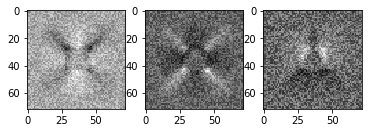

In [70]:
visualize_column(model_sgd)

## Adam optimizer

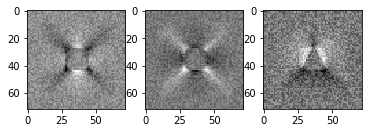

In [67]:
visualize_column(model_adam)

# Question 5 - A More Difficult Classification Problem